# SNN training through PyTorch

With the previous tutorials we have seen how to build a network and run a simulation. These are the necessary elements to start with in order to set up a network for the training towards the classification task, using an externally-provided dataset.

### Note on SHIP:
Spiking (neural network) Hardware In PyTorch is an emulation platform intended for hardware-based SNNs, based on compact models to mimic the behavior and functionalitites of the SNN components, and reliant on a PyTorch backend, so to exploit its available conventional machine-learning techniques.

The development of SHIP has been carried out in CNR-IMM by Emanuele Gemo, Stefano Brivio, Sabina Spiga. This work has been funded by the MeM-Scales research project (https://memscales.eu, Horizon2020 grant agreement no. 871371)

To cite this work, you can refer to the following manuscript, currently submitted to Frontiers In Neuroscience: "SHIP: a computational framework for simulating and validating novel technologies in hardware spiking neural networks", *Front. Neurosci.*, 2023

## Data

We provided a few utilities that come useful to set up a classification training, borrowing the available functions from Torch and TorchVision.
In particular, we will demonstrate how to train a network by use of a subset of the MNIST dataset.

### Download
We start loading the dataset, using the `TorchVisionDataLoader` utility.
We also select a subset of the entire dataset, just in order to speed-up the calculation.
Also for sake of computation requirement, we manually downsize all the data from a 28x28 based set of figures, to a 14x14 based set of figures.

In [1]:
import sys
sys.path.append('C:\\') # to be edited by the user

from SHIP import TorchVisionDataLoader as DL
from torch import (randperm,
                   tensor,
                   arange)

xtrain,ytrain,xtest,ytest = DL('MNIST',standardize = True) #<-- small utility - info on TorchVisionDataLoader in code

### select part of the dataset (raw'n'dirty approach)
idx_tr = randperm(ytrain.shape[0])[:15000] # <-- reduce dataset here
idx_te = randperm(ytest.shape[0])[:1000]  # <-- same goes here
xtrain,ytrain,xtest,ytest = xtrain[idx_tr],ytrain[idx_tr],xtest[idx_te],ytest[idx_te] # <-- apply masks

### manual convolution
_a = tensor([0,1,28,29]);_m = 2; _idx = arange(196).unsqueeze(-1).expand(196,4); 
convmap = 28*(_idx//14)+(_m*_idx+_a)
                  
xtest = xtest[:,convmap].sum(dim=-1).float()
xtrain = xtrain[:,convmap].sum(dim=-1).float()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Em\SHIP - tutorials\data\datasets\torch\MNIST\MNIST\raw



### Encode data onto a spiking dataset
SHIP comes with a couple of utils that allow for a fast conversion of an intensity-based dataset onto a spiking dataset, via use of the time-to-first-spike technique and rate-coding technique.

Here we use the former, `TTFSencoder`, only due to the fact that it is relatively less computationally-intensive than the rate-coding based technique. 
We note that at this stage we already have to choose the number and size of time-steps, as the encoder asks for this parameter to determine the length of the input.

Here's the example:

In [2]:
batch_size = 4 # <-- added for good measure - we will use it later
dt = 0.001
nts = 100


from SHIP import TTFSencoder

xtest = TTFSencoder(xtest, nts,dt)   # converting..
xtrain = TTFSencoder(xtrain, nts,dt) # done.

### Define a 3-layer feedforward network

Here we build a somewhat random network, only to demonstrate how to train it for the classification task we aimed for.

In [3]:
from SHIP import (network,
                  inputN,
                  lifN,
                  lS_1o)

print("build network")
net = network()
net.add(inputN,'I',N=14*14) # <-- first layer
net.add(lifN,'H',N=30, tau_beta = 0.2) # <-- hidden layer
net.add(lifN,'O',N=10,tau_beta = 0.2, is_output = True) # <-- output layer
net.add(lS_1o,'IH',source='I',target='H',w_scale = 100) 
net.add(lS_1o,'HO',source='H',target='O',w_scale = 50)

print("initialize network")
net.init(dt = dt, nts = nts, batch_size = batch_size)

build network
initialize network


## Interfacing the network with PyTorch functionalities: **trainer**

Now that we have a network, we can use the **trainer** class to perform synaptic weight optimization on the SNN. A **trainer** object automates all the operations needed to convert our **network** onto an object that PyTorch can apply its optimizers to. In particular, the available trainer, `SurrGradTrainer`, has been developed on the basis of the work of F. Zenke and collaborators (see  https://ganguli-gang.stanford.edu/pdf/17.superspike.pdf, https://ieeexplore.ieee.org/document/8891809),  also shown in the very-well drawn tutorial found in https://github.com/fzenke/spytorch, 

In little more details, the `SurrGradTrainer` performs the following:
- replaces the neuron model's activation function with a differentiable one where needed
- automatically detects the network's *parameters* (i.e. synaptic weights), as in our models those have always been labelled as *w*;
- through its `get_inference_data` method, it retrieves the output seeking the maximum of a tensor along its 1st dimension (time), and it applies  user-defined pre-processing functions and performs the back-propagation according to an user-defined Torch optimizer.
More elements can be found within the source code, but we refer to the work of the original author to find the reasons of how and why these algorithmic steps work.

To cut it short, and to focus on the demonstration of the platform use, it is sufficient to say that the `SurrGradTrainer` interfaces the network with the PyTorch training routines, and it can be applied for classification task training, provided that the network has a **liN** output model.

However, our network finds a **lifN** object as the output group, which returns spikes - not a membrane potential. Thus, the `SurrGradTrainer` is not directly suitable. We show how to modify the **trainer** so to operate with a spiking output. In practical terms, we need to instruct the trainer to fetch the network inference data as the sum of all spikes along the temporal axis, as follows:

In [4]:
from SHIP import SurrGradTrainer

class TR(SurrGradTrainer): # <-- we inherit the class
    def get_inference_data(self):  # we modify only the get_inference_data function        
        output = self.net.output.sum(dim = 1).float()  # that now seeks the spike count
        return output
    

Internally, such data will be also used to determine the prediction (as the neuron that fires the most).

Now we have a **trainer** that knows how to handle the network output.  We define and initialize such trainer, in parallel to what has been done with a network. We leave the default settings (inference pre-processing through the `torch.nn.LogSoftmax`; cost function as `torch.nn.NLLLoss`; `torch.optim.Adam(lr = 2e-3, betas = 0.9,0.999)`). Those have proven to be sufficient to train the network with the MNIST dataset. Again, more detailed information on the inner working of the trainer can be seen in the notebook of the original authors and related manuscripts.

We therefore build our object:

In [5]:
print("build trainer")
tr = TR(net)
print("initialize trainer")
tr.init()

build trainer
initialize trainer


The **trainer** has been properly set up. Now it is a matter to iteratively run the **network** and the **trainer**, with the **network** receiving the encoded dataset, and the trainer receiving the dataset targets. To do so, we use `TensorHauler`, a function set up to slice the dataset into batches and yielding those sequentially within a for loop structure. 

(tqdm is instead a useful utility that provides a progress bar)

See below:

In [6]:
from SHIP import TensorHauler
from tqdm import tqdm

print("train network - 1 epoch")
ii = 0
for xx,yy in tqdm(TensorHauler(xtrain,ytrain,batch_size), total = len(ytrain)//batch_size):
    net.run(xx)
    tr.run(yy)
    ii+=1
    if ii%100 == 0:
        print("loss value", tr.loss_hist[-1])

train network - 1 epoch


  3%|██▏                                                                            | 101/3750 [00:11<06:56,  8.76it/s]

loss value 2.677175760269165


  5%|████▏                                                                          | 200/3750 [00:23<06:50,  8.64it/s]

loss value 3.0981225967407227


  8%|██████▎                                                                        | 301/3750 [00:34<06:28,  8.88it/s]

loss value 2.268319845199585


 11%|████████▍                                                                      | 401/3750 [00:46<06:15,  8.91it/s]

loss value 2.563570261001587


 13%|██████████▌                                                                    | 501/3750 [00:58<06:06,  8.87it/s]

loss value 2.3376264572143555


 16%|████████████▋                                                                  | 601/3750 [01:10<06:06,  8.59it/s]

loss value 2.4546499252319336


 19%|██████████████▊                                                                | 701/3750 [01:21<05:24,  9.39it/s]

loss value 2.155974864959717


 21%|████████████████▊                                                              | 800/3750 [01:32<05:33,  8.83it/s]

loss value 2.319373607635498


 24%|██████████████████▉                                                            | 901/3750 [01:44<05:15,  9.02it/s]

loss value 2.0107975006103516


 27%|████████████████████▊                                                         | 1001/3750 [01:56<05:15,  8.72it/s]

loss value 2.339735269546509


 29%|██████████████████████▉                                                       | 1101/3750 [02:08<04:50,  9.12it/s]

loss value 2.2626519203186035


 32%|████████████████████████▉                                                     | 1201/3750 [02:19<04:46,  8.89it/s]

loss value 2.3144679069519043


 35%|███████████████████████████                                                   | 1301/3750 [02:31<04:41,  8.70it/s]

loss value 2.5826196670532227


 37%|█████████████████████████████▏                                                | 1401/3750 [02:42<04:37,  8.47it/s]

loss value 2.060262680053711


 40%|███████████████████████████████▏                                              | 1501/3750 [02:54<04:43,  7.94it/s]

loss value 2.5296058654785156


 43%|█████████████████████████████████▎                                            | 1601/3750 [03:06<03:56,  9.08it/s]

loss value 2.1738548278808594


 45%|███████████████████████████████████▍                                          | 1701/3750 [03:17<04:11,  8.15it/s]

loss value 2.585056781768799


 48%|█████████████████████████████████████▍                                        | 1801/3750 [03:29<03:51,  8.43it/s]

loss value 2.444101095199585


 51%|███████████████████████████████████████▌                                      | 1900/3750 [03:40<03:36,  8.55it/s]

loss value 2.673953056335449


 53%|█████████████████████████████████████████▌                                    | 2001/3750 [03:52<04:25,  6.59it/s]

loss value 2.2922396659851074


 56%|███████████████████████████████████████████▋                                  | 2101/3750 [04:06<03:12,  8.58it/s]

loss value 1.8333091735839844


 59%|█████████████████████████████████████████████▊                                | 2201/3750 [04:17<02:52,  9.00it/s]

loss value 1.858086109161377


 61%|███████████████████████████████████████████████▊                              | 2301/3750 [04:29<02:45,  8.78it/s]

loss value 2.1448094844818115


 64%|█████████████████████████████████████████████████▉                            | 2401/3750 [04:40<02:42,  8.30it/s]

loss value 2.113569736480713


 67%|████████████████████████████████████████████████████                          | 2501/3750 [04:53<03:33,  5.85it/s]

loss value 1.6117802858352661


 69%|██████████████████████████████████████████████████████                        | 2601/3750 [05:05<02:10,  8.82it/s]

loss value 1.4174751043319702


 72%|████████████████████████████████████████████████████████▏                     | 2701/3750 [05:16<01:55,  9.10it/s]

loss value 1.7146446704864502


 75%|██████████████████████████████████████████████████████████▎                   | 2801/3750 [05:27<01:44,  9.07it/s]

loss value 1.6458278894424438


 77%|████████████████████████████████████████████████████████████▎                 | 2901/3750 [05:38<01:32,  9.20it/s]

loss value 1.9837543964385986


 80%|██████████████████████████████████████████████████████████████▍               | 3001/3750 [05:49<01:19,  9.39it/s]

loss value 1.731065034866333


 83%|████████████████████████████████████████████████████████████████▌             | 3101/3750 [06:01<01:09,  9.35it/s]

loss value 2.162229537963867


 85%|██████████████████████████████████████████████████████████████████▌           | 3201/3750 [06:12<00:58,  9.33it/s]

loss value 1.8472259044647217


 88%|████████████████████████████████████████████████████████████████████▋         | 3301/3750 [06:23<00:50,  8.83it/s]

loss value 1.1807277202606201


 91%|██████████████████████████████████████████████████████████████████████▋       | 3401/3750 [06:34<00:39,  8.95it/s]

loss value 1.8860242366790771


 93%|████████████████████████████████████████████████████████████████████████▊     | 3501/3750 [06:46<00:29,  8.42it/s]

loss value 1.5116114616394043


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3601/3750 [06:58<00:16,  9.03it/s]

loss value 1.715022087097168


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3701/3750 [07:10<00:05,  8.72it/s]

loss value 1.336279034614563


100%|██████████████████████████████████████████████████████████████████████████████| 3750/3750 [07:15<00:00,  8.61it/s]


It should be visible that the loss function (slowly) decreases with the iteration count. The loss history is also available as a **trainer** property: `trainer.loss_hist`.

Now, to be sure that the training actually works, we repeat the inference simulation with the test dataset, and with the help of the **trainer** we build a confusion matrix:

get confusion matrix and accuracy


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:12<00:00, 20.43it/s]


accuracy = 0.495


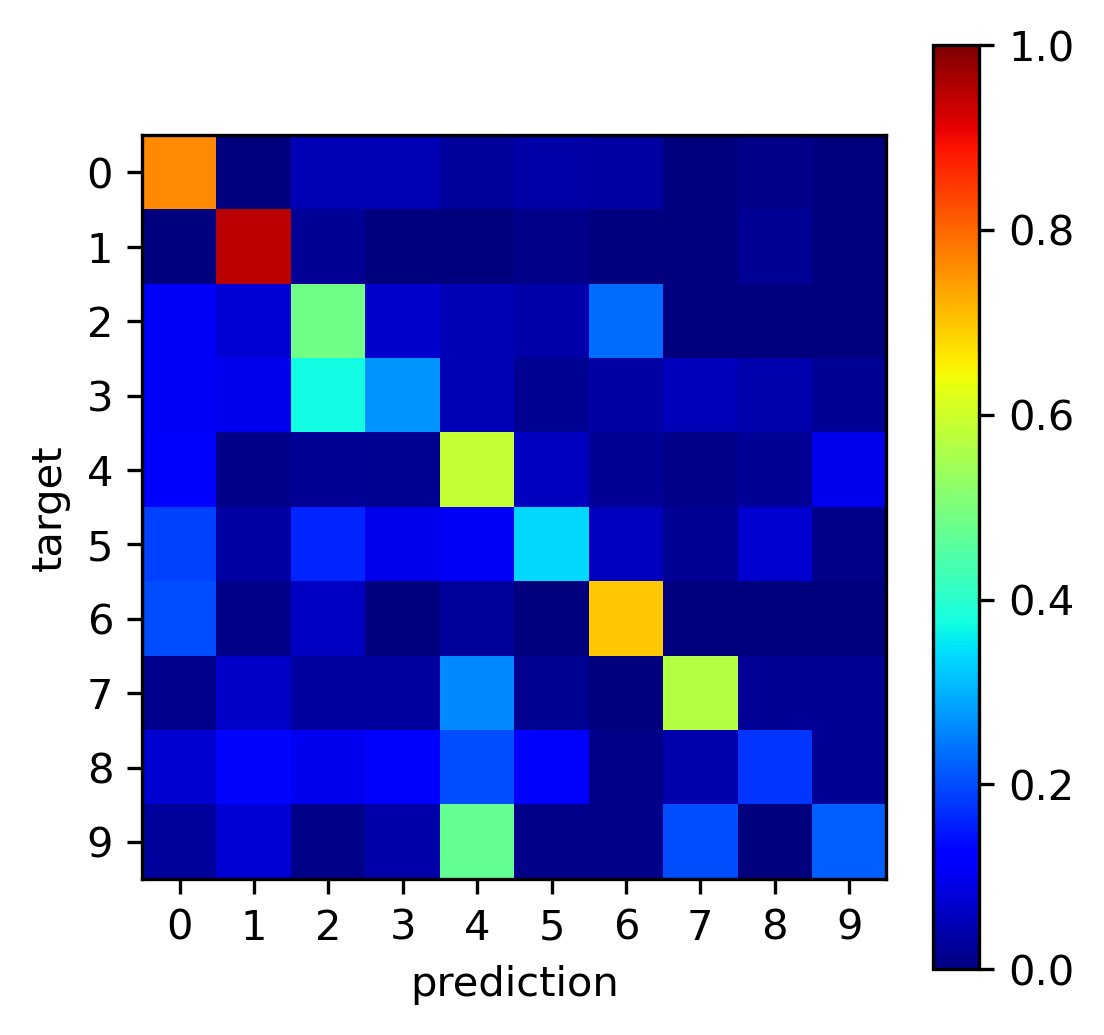

In [7]:
from torch import (zeros, no_grad, eye)

print("get confusion matrix and accuracy")
# get confusion matrix and accuracy        
cm = zeros(10,10)
with no_grad(): # no_grad avoids to unwillingly modify the gradient - 
                # do not know if it would here (should not, but I'll leave no_grad regardless)
    for xx,yy in tqdm(TensorHauler(xtest,ytest,batch_size), total = len(ytest)//batch_size):
        net.run(xx)
        cm[yy,tr.get_prediction()]+=1 # get prediction calls the get_inference_data, 
                                      # and returns the indices of the peak values per-batch.
        
cmn = cm/cm.sum(dim=1) # normalize by sample count (per sample class)

# plotting the results here
import matplotlib.pyplot as plt
labels = arange(10)
f,ax = plt.subplots(1,1,dpi = 300, figsize = (4,4))   
pp = ax.imshow(cmn,cmap = "jet",vmin = 0, vmax = 1); plt.colorbar(pp)
ax.set_xticks(labels.numpy(),labels=labels.numpy())
ax.set_ylabel('target')
ax.set_yticks(labels.numpy(),labels=labels.numpy())
ax.set_xlabel('prediction')

# and printing the accuracy, as the sum of the confusion_matrix diagonal elements
print("accuracy = %0.3f"%((cm*eye(10)).sum()/cm.sum()))

After one epoch, and using a limited portion of the original dataset (also reduced in resolution), we manage to find a certain degree of diagonalization of the confusion matrix, and an accuracy which should be close to 50% (this value varies with chance).


## Conclusion
Concluding, this part of the tutorial shows the essentials on how to train a SNN in SHIP for classification tasks. Much can be changed, from the data source, to the data encoding, to the details of how the trainer fetches, preprocesses the inference data and calculates and apply the synaptic weights update. However, the main elements are here gathered, and much more complex tasks can be derived from this simplistic example.